# Using MUR SST Kerchunk Store

From: https://github.com/pangeo-gallery/osm2020tutorial/blob/master/AWS-notebooks


# 1. Opening data



-------------------

## Import python packages

It is nice to turn off warnings and set xarray display options.  

In [1]:
import warnings
import fsspec
import metpy
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import os
import sys
sys.path.append(os.path.join(os.environ['HOME'], 'shared', 'users', 'lib'))
import ebdpy as ebd

warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 

### Start a cluster, a group of computers that will work together.

(A cluster is the key to big data analysis on on Cloud.)

- This will set up a [dask kubernetes](https://docs.dask.org/en/latest/setup/kubernetes.html) cluster for your analysis and give you a path that you can paste into the top of the Dask dashboard to visualize parts of your cluster.  
- You don't need to paste the link below into the Dask dashboard for this to work, but it will help you visualize progress.
- Try 20 workers to start (during the tutorial) but you can increase to speed things up later

In [10]:
ebd.set_credentials(profile='aimee')

profile = 'aimee'
region = 'us-west-2'
endpoint = f's3.{region}.amazonaws.com'
ebd.set_credentials(profile=profile, region=region, endpoint=endpoint)
worker_max = 8


client, cluster = ebd.start_dask_cluster(profile=profile,
                                        worker_max=worker_max, 
                                        region=region,
                                        use_existing_cluster=True,
                                        adaptive_scaling=False,
                                        wait_for_cluster=True, 
                                        worker_profile='Pangeo Worker', 
                                        propagate_env=True)

Region: us-west-2
Existing Dask clusters:
Cluster Index c_idx: 0 / Name: dev.1164cb10515b45618885b532f57ddefc ClusterStatus.RUNNING
Cluster Index c_idx: 1 / Name: dev.26e9bd587eb944c89db9dcefd3e65b01 ClusterStatus.RUNNING
Cluster Index c_idx: 2 / Name: dev.c3682651305b4df1a5567b3559922d36 ClusterStatus.RUNNING
Starting new cluster.
{}
Setting Cluster Environment Variable AWS_DEFAULT_REGION us-west-2
Setting Fixed Scaling workers=8
Reconnect client to clear cache
client.dashboard_link (for new browser tab/window or dashboard searchbar in Jupyterhub):
https://jupyter.qhub.esipfed.org/gateway/clusters/dev.bf18dd629f3a4ebea6715843a7e96acf/status
Elapsed time to wait for 8 live workers:
8/8 workers - 8 seconds
Propagating environment variables to workers
Using environment: users/pangeo


** ☝️ Don’t forget to click the link above or copy it to the Dask dashboard 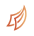 on the left to view the scheduler dashboard! **

### Initialize Dataset

Here we load the dataset from the zarr store. Note that this very large dataset initializes nearly instantly, and we can see the full list of variables and coordinates.

### Examine Metadata

For those unfamiliar with this dataset, the variable metadata is very helpful for understanding what the variables actually represent
Printing the dataset will show you the dimensions, coordinates, and data variables with clickable icons at the end that show more metadata and size.

In [11]:
%%time
fs = fsspec.filesystem(
    'reference', 
    fo="../../2022-esip-kerchunk-tutorial/combined.json", 
    remote_protocol='s3', 
    remote_options=dict(profile='aimee'), 
    skip_instance_cache=True
)
ds_sst = xr.open_dataset(fs.get_mapper(""), engine='zarr').metpy.parse_cf()
ds_sst

CPU times: user 1.36 s, sys: 112 ms, total: 1.48 s
Wall time: 1.57 s


<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 365)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2003-05-3...
    metpy_crs         object Projection: latitude_longitude
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20020601T210000Z
    time_coverage_start:        20020531T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

CPU times: user 9.75 s, sys: 784 ms, total: 10.5 s
Wall time: 1min 5s


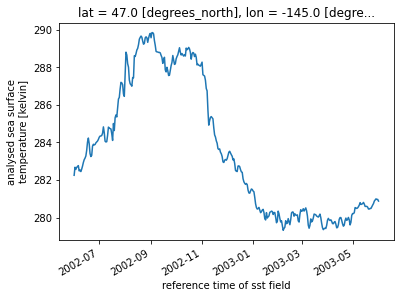

In [20]:
%%time

sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2002-06-01','2003-05-31'),
                                            lat  = 47,
                                            lon  = -145
                                           ).load()

sst_timeseries.plot()

``xarray`` plotting functions rely on matplotlib internally, but they make use of all available metadata to make the plotting operations more intuitive and interpretable. More plotting examples are given [here](http://xarray.pydata.org/en/stable/plotting.html)

### Here we use ``holoviews`` and ``hvplot`` for interactive graphics

In [ ]:
import hvplot.xarray
import holoviews as hv
from holoviews.operation.datashader import regrid
hv.extension('bokeh')

### Plot the SST anomaly timeseries


In [ ]:
%%time

analysed_sst = sst_subset['analysed_sst']

analysed_sst.hvplot(grid=True, groupby=['time'], height=800, width=1000) 

In [ ]:
analysed_sst.mean(dim=['lat', 'lon']).hvplot()

### Plotting on maps

For plotting on maps, we rely on the excellent [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html) library.

In [ ]:
import cartopy.crs as ccrs
import geoviews.feature as gf

### Load a global image of SST on 9/1/2016

### In cartopy you need to define the map projection you want to plot.  

- Common ones are Ortographic and PlateCarree.
- You can add coastlines and gridlines to the axes as well.

In [ ]:
%%time

sst_dy = ds_sst.sel(time='2002-06-01T09').load()

basemap = gf.land() * gf.coastline() * gf.borders()

mur_whole = sst_dy.sel(lat=slice(-70,80)).hvplot.quadmesh(x='lon', 
                                                          y='lat', 
                                                          rasterize=True, 
                                                          geo=True, 
                                                          cmap='turbo',    
                                                          frame_width=400)

mur_whole * basemap

In [ ]:
crs = ccrs.Orthographic(central_longitude=-70, central_latitude=30) #set projection

mur_globe = sst_dy.hvplot.quadmesh(x='lon', 
                                   y='lat', 
                                   rasterize=True, 
                                   projection=crs,      
                                   cmap='turbo',        
                                   frame_width=400)

mur_globe * basemap

## Please close cluster

In [1]:
client.close()
cluster.close()

NameError: name 'client' is not defined

## A nice cartopy tutorial is [here](http://earthpy.org/tag/visualization.html)